In [1]:
import os
import subprocess

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from ase.build import bulk
from ase.calculators.espresso import Espresso
from ase.io import write
from pwtools import io

# Functions

In [4]:
def write_input_calc_minimize(input_dict, working_directory="."):
    filename = os.path.join(working_directory, 'relax.pwi')
    os.makedirs(working_directory, exist_ok=True)
    input_data_relax = {
        'calculation': 'vc-relax',
        'cell_dofree': 'ibrav',
    }
    write(
        filename=filename, 
        images=input_dict["structure"], 
        Crystal=True, 
        kpts=input_dict["kpts"], 
        input_data=input_data_relax, 
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True, 
        tprnfor=True
    )

In [5]:
def write_input_calc_static(input_dict, working_directory="."):
    filename = os.path.join(working_directory, 'static.pwi')
    os.makedirs(working_directory, exist_ok=True)
    input_data_static = {
        'calculation': 'scf', # A string describing the task to be performed.
    }
    write(
        filename=filename, 
        images=input_dict["structure"], 
        Crystal=True, 
        kpts=input_dict["kpts"], 
        input_data=input_data_static, 
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True, 
        tprnfor=True
    )

In [6]:
def collect_output_calc_minimize(working_directory="."):
    filename = os.path.join(working_directory, 'relax.pwo')
    # return {"structure": io.read_pw_md(filename)[-1].get_ase_atoms()}
    return {"structure": io.read_pw_md(filename)[-1].get_ase_atoms()}

In [7]:
def collect_output_calc_static(working_directory="."):
    filename = os.path.join(working_directory, 'static.pwo')
    out = io.read_pw_scf(filename)
    return {
        "energy": out.etot,
        "volume": out.volume,
    }

# pyiron_base

In [8]:
from pyiron_base.jobs.job.template import TemplateJob
from pyiron_base.jobs.job.extension.executable import Executable

In [9]:
class QEMinimize(TemplateJob):
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        self.input.update({  # Default Parameter 
            "structure": None, 
            "pseudopotentials": pseudopotentials, 
            "kpts": (3, 3, 3),
        })
        self.executable = "mpirun -np 1 pw.x -in relax.pwi > relax.pwo"

    def write_input(self):
        write_input_calc_minimize(input_dict=self.input.to_builtin(), working_directory=self.working_directory)

    def collect_output(self):
        self.output.update(collect_output_calc_minimize(working_directory=self.working_directory))
        self.to_hdf()

In [10]:
class QEStatic(TemplateJob):
    def __init__(self, project, job_name):
        super().__init__(project, job_name)
        self.input.update({  # Default Parameter 
            "structure": None, 
            "pseudopotentials": pseudopotentials, 
            "kpts": (3, 3, 3),
        })
        self.executable = "mpirun -np 1 pw.x -in static.pwi > static.pwo"

    def write_input(self):
        write_input_calc_static(input_dict=self.input.to_builtin(), working_directory=self.working_directory)

    def collect_output(self):
        self.output.update(collect_output_calc_static(working_directory=self.working_directory))
        self.to_hdf()

# Workflow

In [11]:
from pyiron_base import Project

## Structure Optimization

In [12]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [13]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
structure = bulk('Al', a=4.15, cubic=True)

In [15]:
job_qe_minimize = pr.create_job(job_type=QEMinimize, job_name="qe_relax")

In [16]:
job_qe_minimize.input

DataContainer({'structure': None, 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'kpts': (3, 3, 3)})

In [17]:
job_qe_minimize.input.structure = structure

In [18]:
job_qe_minimize.run()

The job qe_relax was saved and received the ID: qe_relax


In [19]:
structure_opt = job_qe_minimize.output.structure
structure_opt

Atoms(symbols='Al4', pbc=False, cell=[4.138924021999999, 4.138924021999999, 4.138924021999999])

## Energy Volume Curve

In [20]:
energy_lst, volume_lst = [], []
for i, strain in enumerate(np.linspace(0.9, 1.1, 5)):
    structure_strain = structure_opt.copy()
    structure_strain = structure.copy()
    structure_strain.set_cell(structure_strain.cell * strain**(1/3), scale_atoms=True)
    job_strain = pr.create_job(job_type=QEStatic, job_name="job_strain_" + str(i))
    job_strain.input.structure = structure_strain
    job_strain.run(delete_existing_job=True)
    energy_lst.append(job_strain.output.energy)
    volume_lst.append(job_strain.output.volume)

The job job_strain_0 was saved and received the ID: job_strain_0
The job job_strain_1 was saved and received the ID: job_strain_1
The job job_strain_2 was saved and received the ID: job_strain_2
The job job_strain_3 was saved and received the ID: job_strain_3
The job job_strain_4 was saved and received the ID: job_strain_4


# Result

Text(0, 0.5, 'Energy')

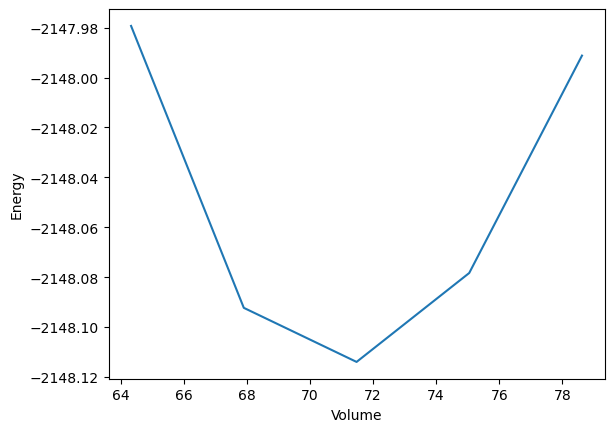

In [21]:
plt.plot(volume_lst, energy_lst)
plt.xlabel("Volume")
plt.ylabel("Energy")

# Summary

In [22]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,hamilton,hamversion,timestart,computer,parentid,username,timestop,totalcputime,masterid
0,1,finished,None,qe_relax,/qe_relax,None,/home/janssen/notebooks/2024/2024-01-03-quantum-espresso/test/,QEMinimize,mpirun -np 1 pw.x -in relax.pwi > relax.pwo,2024-01-10 16:36:39.650314,None,None,None,2024-01-10 16:36:39.650314,0.0,None
1,2,finished,None,job_strain_0,/job_strain_0,None,/home/janssen/notebooks/2024/2024-01-03-quantum-espresso/test/,QEStatic,mpirun -np 1 pw.x -in static.pwi > static.pwo,2024-01-10 16:37:33.452269,None,None,None,2024-01-10 16:37:33.452269,0.0,None
2,3,finished,None,job_strain_1,/job_strain_1,None,/home/janssen/notebooks/2024/2024-01-03-quantum-espresso/test/,QEStatic,mpirun -np 1 pw.x -in static.pwi > static.pwo,2024-01-10 16:38:15.913475,None,None,None,2024-01-10 16:38:15.913475,0.0,None
3,4,finished,None,job_strain_2,/job_strain_2,None,/home/janssen/notebooks/2024/2024-01-03-quantum-espresso/test/,QEStatic,mpirun -np 1 pw.x -in static.pwi > static.pwo,2024-01-10 16:38:34.744407,None,None,None,2024-01-10 16:38:34.744407,0.0,None
4,5,finished,None,job_strain_3,/job_strain_3,None,/home/janssen/notebooks/2024/2024-01-03-quantum-espresso/test/,QEStatic,mpirun -np 1 pw.x -in static.pwi > static.pwo,2024-01-10 16:38:41.853381,None,None,None,2024-01-10 16:38:41.853381,0.0,None
5,6,finished,None,job_strain_4,/job_strain_4,None,/home/janssen/notebooks/2024/2024-01-03-quantum-espresso/test/,QEStatic,mpirun -np 1 pw.x -in static.pwi > static.pwo,2024-01-10 16:38:59.696323,None,None,None,2024-01-10 16:38:59.696323,0.0,None
